In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mesh_width = 5  # количество ячеек по пространству
mesh_height = 1000  # количество ячеек по времени

In [3]:
dt = 10  # сут, временной шаг
dt *= 24 * 60 * 60  # с, временной шаг

m = 0.15  # пористость

mu = 5  # мПа*с, вязкость жидкости
mu *= 1e-3  # Па*с, вязкость жидкости

k = 5  # мД, проницаемость
k *= 1e-3 * (1e-6) ** 2  # м^2, проницаемость

dx = 100  # м, длина ячейки

c = 2.4e-9  # Па^(-1), общая сжимаемость

a = 10000  # м^2, площадь поверхности боковой грани ячейки

p_initial = 19  # МПа, начальное давление в ячейках

q_left = 6  # м^3/сут, расход на левой границе
q_left /= (24 * 60 * 60)  # м^3/с, расход на левой границе

p_right = 20  # МПа, давление на правой границе

In [4]:
# безразмерный множитель
dimless_mult = (dt / dx ** 2) * (k / (m * mu * c))
dimless_mult

0.24000000000000007

In [5]:
p_values = np.zeros([mesh_height, mesh_width])
p_values[0][:] = p_initial

In [6]:
for t_ind in range(1, mesh_height):
    p_values[t_ind][0] = p_values[t_ind - 1][0] + \
        dimless_mult * (p_values[t_ind - 1][1] - p_values[t_ind - 1][0] + q_left * mu / (a * k) * dx / 1e6)
    p_values[t_ind][-1] = p_values[t_ind - 1][-1] + \
        4 / 3 * dimless_mult * (2 * p_right - 3 * p_values[t_ind - 1][-1] + p_values[t_ind - 1][-2])
     
    for x_ind in range(1, mesh_width - 1):
        p_values[t_ind][x_ind] = p_values[t_ind - 1][x_ind] + \
        dimless_mult * (p_values[t_ind - 1][x_ind + 1] - 2 * p_values[t_ind - 1][x_ind] + p_values[t_ind - 1][x_ind - 1])

In [7]:
p_values

array([[19.        , 19.        , 19.        , 19.        , 19.        ],
       [19.16666667, 19.        , 19.        , 19.        , 19.64      ],
       [19.29333333, 19.04      , 19.        , 19.1536    , 19.6656    ],
       ...,
       [23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222],
       [23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222],
       [23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222]])

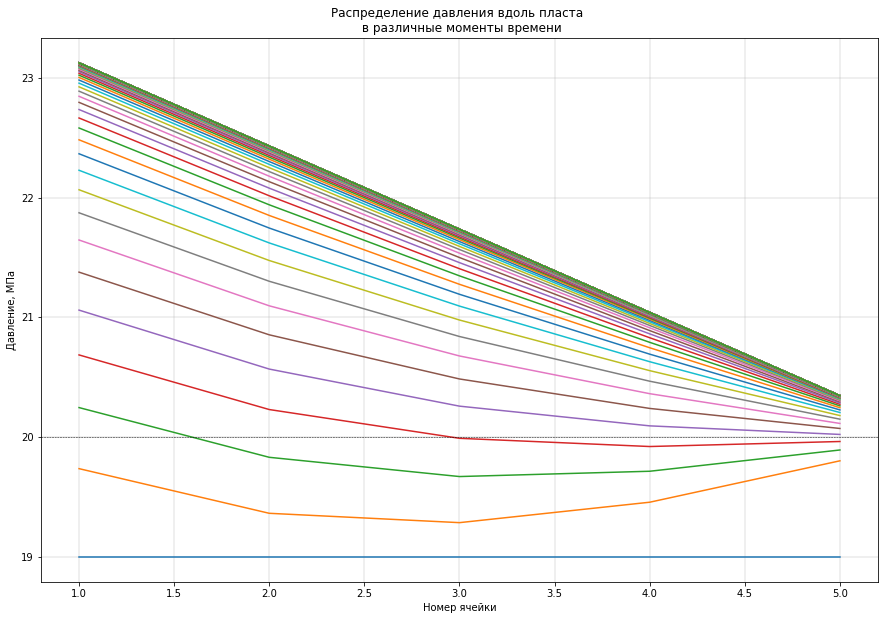

In [8]:
fig = plt.figure(figsize=(15,10))
for i in p_values[::7]:
    plt.plot(range(1, 6), i)

plt.title('Распределение давления вдоль пласта \n в различные моменты времени')
plt.xlabel('Номер ячейки')
plt.ylabel('Давление, МПа')

plt.axhline(y=20.0, color='black', linestyle='--', linewidth=0.5)
plt.grid(linewidth=0.4)
plt.show()